<a name='1'> </a>

# 1-Import Packages

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

df_train=pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')

df_test=pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

<a name='2'></a>

# 2-Data Exploration

In [2]:
df_train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,19219.0,9.609000e+03,5.548192e+03,0.0000,4804.50000,9.609000e+03,1.441350e+04,1.921800e+04
X_Minimum,19219.0,7.098547e+02,5.315442e+02,0.0000,49.00000,7.770000e+02,1.152000e+03,1.705000e+03
X_Maximum,19219.0,7.538576e+02,4.998366e+02,4.0000,214.00000,7.960000e+02,1.165000e+03,1.713000e+03
Y_Minimum,19219.0,1.849756e+06,1.903554e+06,6712.0000,657468.00000,1.398169e+06,2.368032e+06,1.298766e+07
Y_Maximum,19219.0,1.846605e+06,1.896295e+06,6724.0000,657502.00000,1.398179e+06,2.362511e+06,1.298769e+07
Pixels_Areas,19219.0,1.683988e+03,3.730320e+03,6.0000,89.00000,1.680000e+02,6.530000e+02,1.526550e+05
X_Perimeter,19219.0,9.565466e+01,1.778214e+02,2.0000,15.00000,2.500000e+01,6.400000e+01,7.553000e+03
Y_Perimeter,19219.0,6.412410e+01,1.010542e+02,1.0000,14.00000,2.300000e+01,6.100000e+01,9.030000e+02
Sum_of_Luminosity,19219.0,1.918467e+05,4.420247e+05,250.0000,9848.00000,1.823800e+04,6.797800e+04,1.159141e+07
Minimum_of_Luminosity,19219.0,8.480842e+01,2.880034e+01,0.0000,70.00000,9.000000e+01,1.050000e+02,1.960000e+02


In [5]:
id_train=df_train['id']

id_test=df_test['id']

df_train.drop(columns='id',inplace=True)

df_test.drop(columns='id',inplace=True)


In [6]:
df_train.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [7]:
df_train.duplicated().sum()

0

### Data Splitting

Split the Label and Target Columns

In [8]:
X_columns=df_test.columns

y_columns = [item for item in df_train.columns if item not in X_columns]

In [9]:
y_columns

['Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [10]:
X_train,y_train=df_train[X_columns],df_train[y_columns]

X_test=df_test.copy()

In [11]:
TARGETS = y_columns
TARGETS

['Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [12]:
df_train['Outside_Global_Index'].value_counts()

Outside_Global_Index
1.0    11022
0.0     7490
0.5      706
0.7        1
Name: count, dtype: int64

Split Categorical Columns from Numerical Columns

In [13]:
for i in X_columns:

    print(i,df_train[i].nunique())

    print('---')


X_Minimum 1191
---
X_Maximum 1259
---
Y_Minimum 3345
---
Y_Maximum 3341
---
Pixels_Areas 1154
---
X_Perimeter 460
---
Y_Perimeter 331
---
Sum_of_Luminosity 2595
---
Minimum_of_Luminosity 162
---
Maximum_of_Luminosity 98
---
Length_of_Conveyer 99
---
TypeOfSteel_A300 2
---
TypeOfSteel_A400 2
---
Steel_Plate_Thickness 27
---
Edges_Index 1849
---
Empty_Index 1748
---
Square_Index 1118
---
Outside_X_Index 525
---
Edges_X_Index 1102
---
Edges_Y_Index 900
---
Outside_Global_Index 4
---
LogOfAreas 1072
---
Log_X_Index 206
---
Log_Y_Index 241
---
Orientation_Index 1598
---
Luminosity_Index 2046
---
SigmoidOfAreas 467
---


In [14]:
cat_col=[]

num_col=[]

for i in X_columns:

    if df_train[i].nunique()<=4:

        cat_col.append(i)

    else:

        num_col.append(i)

In [15]:
print(cat_col)

print(num_col)

['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']
['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']


<a name='3'> </a>

# 3-Data Visualization

### Plot Categorical Columns

In [16]:
df_train[cat_col].columns

Index(['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index'], dtype='object')

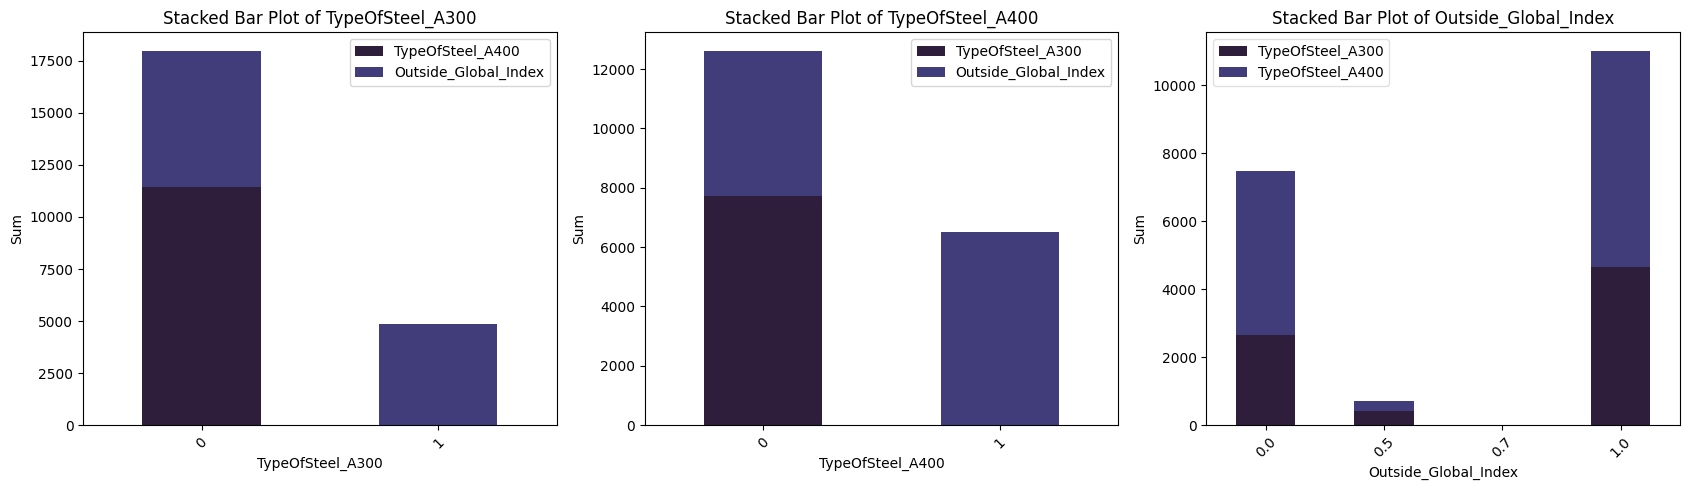

In [17]:


# Calculate number of rows and columns for subplots

num_plots = len(cat_col)

num_cols = 3  # Number of columns in the subplot grid

num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate number of rows

#Set Pallete

sns.set_palette('mako')

# Create subplots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, 5*num_rows))

# Flatten the axes array if it's multidimensional

axes = axes.flatten()



# Create a stacked bar plot for each categorical column

for i, column in enumerate(cat_col):

    ax = axes[i]

    df_train[cat_col].groupby(column).sum().plot(kind='bar', stacked=True, ax=ax)

    ax.set_title(f'Stacked Bar Plot of {column}')

    ax.set_xlabel(column)

    ax.set_ylabel('Sum')

    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    

    handles, labels = ax.get_legend_handles_labels()

        

# Add a single legend for the entire subplot



leg = plt.legend()

leg.get_frame().set_alpha(0.6) 

# Hide any empty subplots

for j in range(i + 1, len(axes)):

    axes[j].axis('off')



plt.tight_layout()

plt.show()

## Plot Numerical Columns

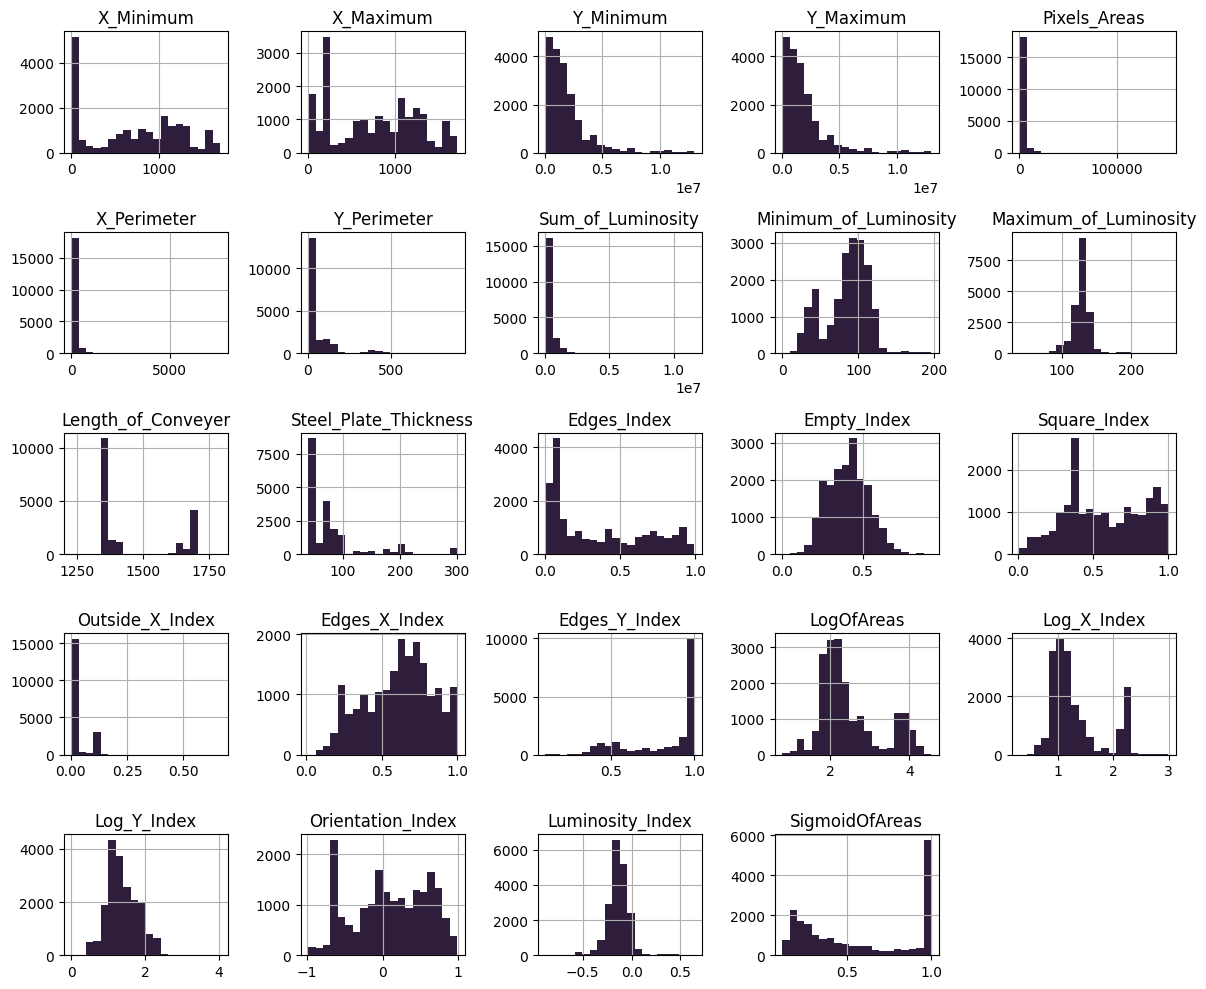

In [18]:
df_train[num_col].hist(bins=20,figsize=(12,10))

plt.tight_layout()

plt.show()

## Plot Target Columns

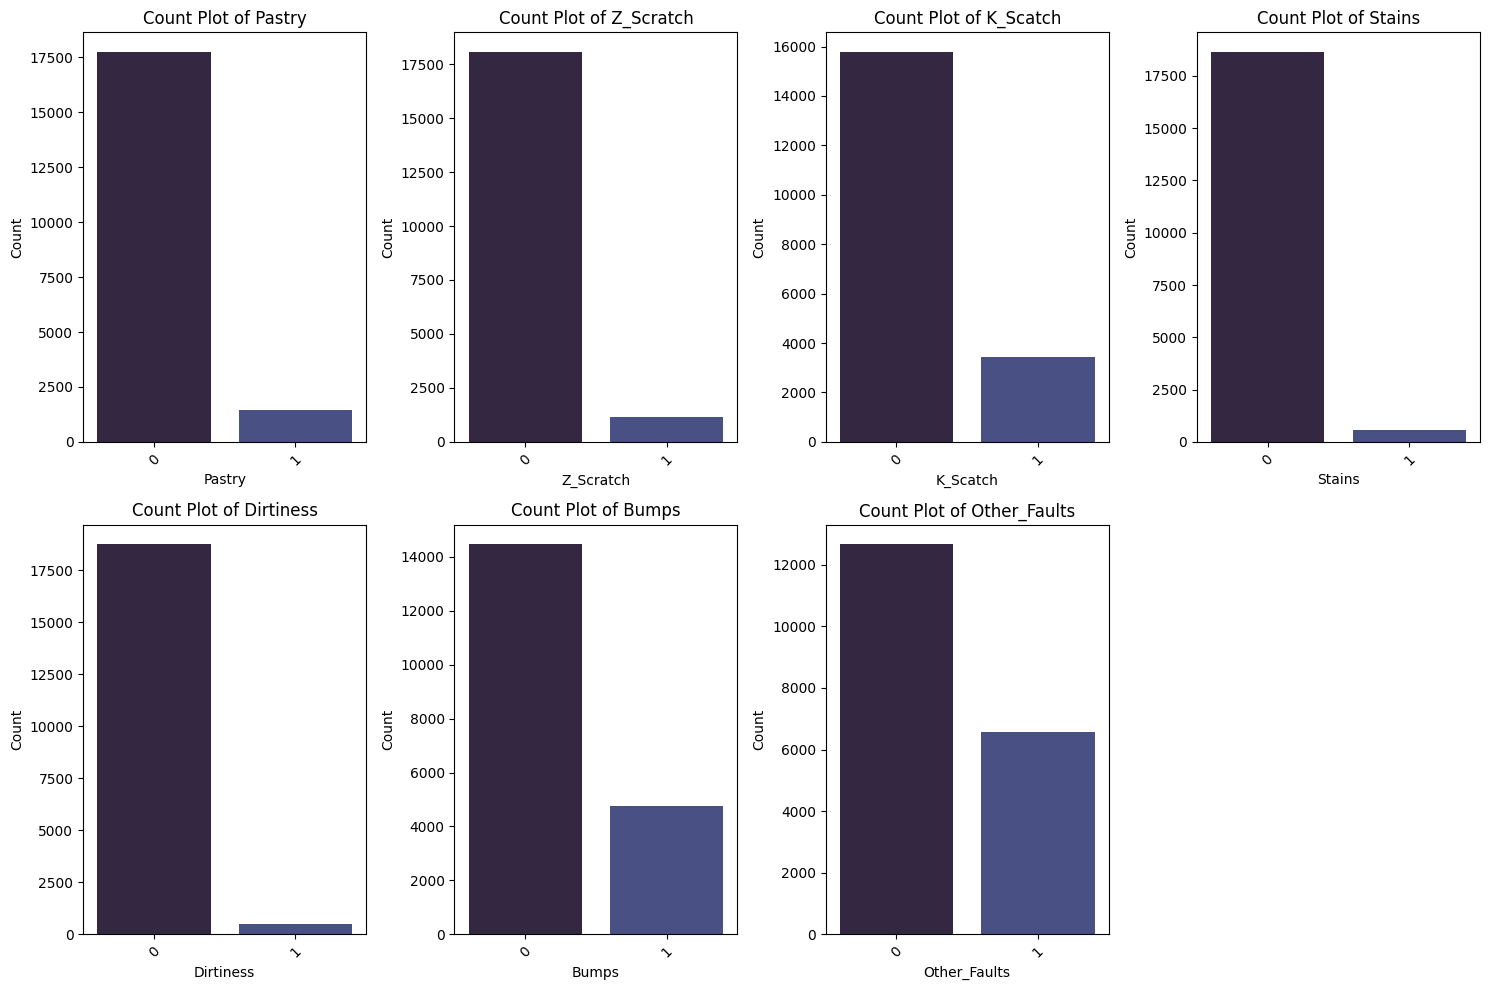

In [19]:
palette=sns.color_palette('mako',5)

num_plots = len(y_columns)

num_cols = 4  # Number of columns in the plot grid

num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

axes = axes.flatten()  # Flatten the axes array if it's multidimensional

for i, column in enumerate(y_columns):

    ax = axes[i]

    sns.countplot(x=column, data=df_train, ax=ax,palette=palette)

    ax.set_title(f'Count Plot of {column}')

    ax.set_xlabel(column)

    ax.set_ylabel('Count')

    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

#Remove Empty spaces

for j in range(i + 1, len(axes)):

    axes[j].axis('off')

plt.tight_layout()

plt.show()

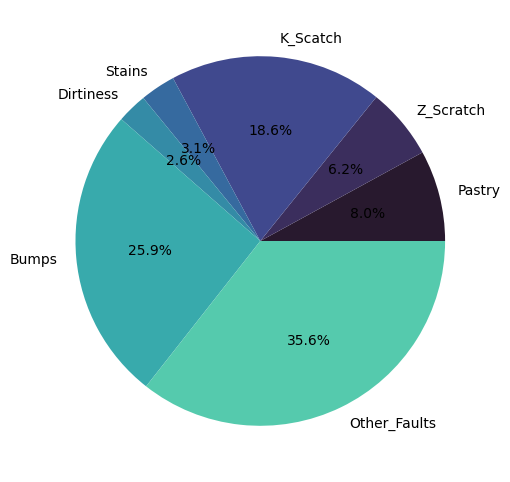

In [20]:
# Check repartition on the target classes

custom_palette = sns.color_palette("mako", 8)
extra_color = "purple"
custom_palette.append(extra_color)

sns.set_palette(custom_palette)

targets = df_train.iloc[:, -7:].sum()

plt.figure(figsize=(6, 6))
plt.pie(targets.values, labels=targets.index, autopct='%1.1f%%')
plt.show()

## Plot Colinearity

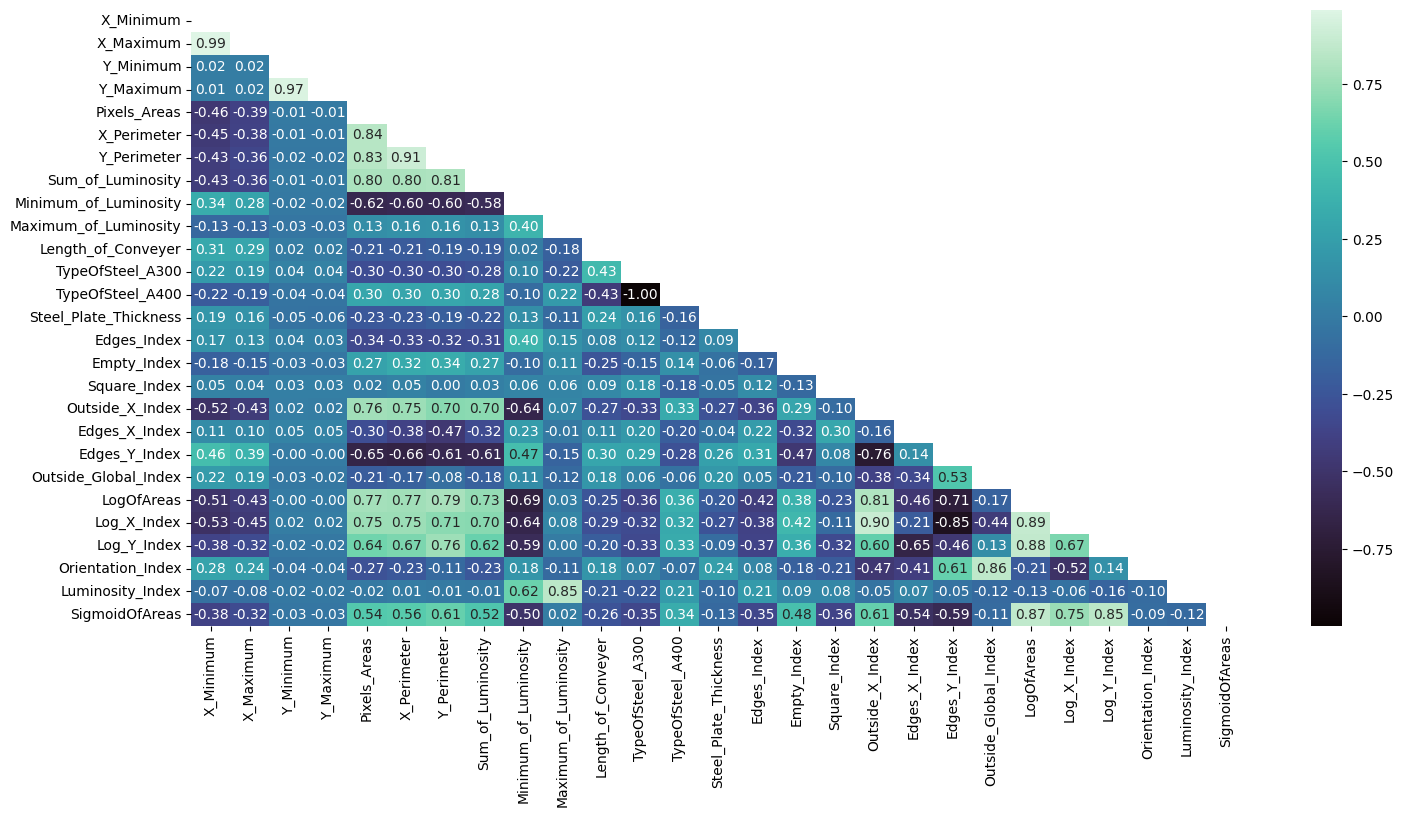

In [21]:
corr = df_train[X_columns].corr(numeric_only=True)

mask = np.triu(corr)

mask=mask

plt.figure(figsize=(17, 8))

sns.heatmap(corr, annot=True,mask=mask, cmap='mako', fmt='.2f')

plt.show()

<a name='4'> </a>



# 4-Preprocessing & ML Packages

In [22]:
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.metrics import make_scorer, accuracy_score,classification_report,f1_score,mean_squared_error,roc_auc_score,precision_score,recall_score,roc_curve,ConfusionMatrixDisplay,confusion_matrix,auc

from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder,RobustScaler,MinMaxScaler

from sklearn.compose import ColumnTransformer

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression,SGDClassifier, RidgeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

from sklearn.svm import SVC

from sklearn.base import BaseEstimator,TransformerMixin

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from sklearn.multioutput import MultiOutputClassifier

from imblearn.over_sampling import BorderlineSMOTE

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelBinarizer

from optuna.samplers import TPESampler

from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

from sklearn.impute import SimpleImputer

from imblearn.over_sampling import BorderlineSMOTE

from catboost import CatBoostClassifier

import numpy as np

import optuna

## Handeling Outliers

In [23]:
#Outlier Equation

def outlier_threshhold(dataframe,column,q1=0.25,q3=0.75):

    Q1=dataframe[column].quantile(q1)

    Q3=dataframe[column].quantile(q3)

    iqr=Q3-Q1

    up_limit=Q3+1.5*iqr

    low_limit=Q1-1.5*iqr

    return low_limit,up_limit



#Outlier Count    

def outlier_percentage(dataframe, column):

    low_limit, up_limit = outlier_threshhold(dataframe, column)

    outliers = [x for x in dataframe[column] if (x > up_limit) or (x < low_limit)]  # Changed | to or

    print(column)  # Changed col to column

    print("Outliers percentage:", len(outliers) / dataframe[column].shape[0] * 100, "%")

    # print("Outliers Count :", len(outliers))

    print("-------------------------")



#Checking Outliers 

def check_outliers(dataframe,column):

    low_limit,up_limit=outlier_threshhold(dataframe,column)

    outliers=(dataframe[column]>up_limit) | (dataframe[column]<low_limit)

    if outliers.any():

        return True

    else:

        return False

#Replace with IQR     

def replace_with_threshholds(dataframe,dataframe2,column):

    low_limit,up_limit=outlier_threshhold(dataframe,column)

    dataframe.loc[(dataframe[column]<low_limit),column]=low_limit

    dataframe.loc[(dataframe[column]>up_limit),column]=up_limit

    dataframe2.loc[(dataframe2[column]<low_limit),column]=low_limit

    dataframe2.loc[(dataframe2[column]>up_limit),column]=up_limit  





for col in (num_col):

    outlier_percentage(df_train,col)

X_Minimum
Outliers percentage: 0.0 %
-------------------------
X_Maximum
Outliers percentage: 0.0 %
-------------------------
Y_Minimum
Outliers percentage: 5.817160101982413 %
-------------------------
Y_Maximum
Outliers percentage: 5.785940995889485 %
-------------------------
Pixels_Areas
Outliers percentage: 19.366252146313546 %
-------------------------
X_Perimeter
Outliers percentage: 19.340236224569438 %
-------------------------
Y_Perimeter
Outliers percentage: 14.490868411467819 %
-------------------------
Sum_of_Luminosity
Outliers percentage: 19.907383318590977 %
-------------------------
Minimum_of_Luminosity
Outliers percentage: 1.097871897601332 %
-------------------------
Maximum_of_Luminosity
Outliers percentage: 6.722514178677351 %
-------------------------
Length_of_Conveyer
Outliers percentage: 0.0 %
-------------------------
Steel_Plate_Thickness
Outliers percentage: 11.306519589989074 %
-------------------------
Edges_Index
Outliers percentage: 0.0 %
--------------

In [24]:
for column in num_col:

    replace_with_threshholds(df_train,df_test,column)

    print(column,check_outliers(df_train,column))

X_Minimum False
X_Maximum False
Y_Minimum False
Y_Maximum False
Pixels_Areas False
X_Perimeter False
Y_Perimeter False
Sum_of_Luminosity False
Minimum_of_Luminosity False
Maximum_of_Luminosity False
Length_of_Conveyer False
Steel_Plate_Thickness False
Edges_Index False
Empty_Index False
Square_Index False
Outside_X_Index False
Edges_X_Index False
Edges_Y_Index False
LogOfAreas False
Log_X_Index False
Log_Y_Index False
Orientation_Index False
Luminosity_Index False
SigmoidOfAreas False


### Enter the new Split Labeled and Target Columns

In [25]:
X_train,y_train=df_train[X_columns],df_train[y_columns]

X_test=df_test

In [26]:
print("The Shape of X_train is :",X_train.shape)

print("The Shape of y_train is :",y_train.shape)

print("The Shape of X_test is :",X_test.shape)


The Shape of X_train is : (19219, 27)
The Shape of y_train is : (19219, 7)
The Shape of X_test is : (12814, 27)


## Detect Skewed Columns

In [27]:
import pandas as pd



def detect_skewness(dataframe, threshold=0.5):

    """

    Detects left or right skewed columns in a pandas DataFrame.



    Parameters:

    dataframe (pandas DataFrame): The DataFrame to analyze.

    threshold (float): The threshold for considering a column as skewed.

                      Default is 0.5.



    Returns:

    skewed_columns (list): A list of column names that are skewed.

    """

    skewed_columns = []



    for column in dataframe.columns:

        skewness = dataframe[column].skew()

        if abs(skewness) > threshold:

            #skewed.append((column, skewness))

            skewed_columns.append(column)

            
    return skewed_columns 

skewed_cols = detect_skewness(df_train[num_col])

print("Skewed columns:", skewed_cols)

Skewed columns: ['Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Outside_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index']


## Custom Transformers

In [28]:
class SMOTETransformer(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply BorderlineSMOTE oversampling to a specified dataset.

    Parameters
    ----------
    k_neighbors : int, default=5
        Number of nearest neighbors to be used by BorderlineSMOTE.

    m_neighbors : int, default=10
        Number of nearest neighbors to be used by BorderlineSMOTE.

    random_state : int, default=42
        Random seed for reproducibility.
    """

    def __init__(self, k_neighbors=5, m_neighbors=10, random_state=42):
        self.k_neighbors = k_neighbors
        self.m_neighbors = m_neighbors
        self.random_state = random_state
        self.smote = BorderlineSMOTE(
            k_neighbors=self.k_neighbors,
            m_neighbors=self.m_neighbors,
            random_state=self.random_state
        )

    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        X_resampled, y_resampled = self.smote.fit_resample(X, y)
        return X_resampled, y_resampled

    def transform(self, X, y=None):
        return X, y  # Pass-through if called in transform-only mode.


In [29]:
class OrdinalEncodeColumns(BaseEstimator, TransformerMixin):

    """

    Transformer class to perform ordinal encoding on specified columns of a Pandas DataFrame.



    Parameters

    ----------

    columns : list of str

        The names of the ordinal columns to encode.



    Returns

    -------

    pandas.DataFrame

        A new DataFrame with the ordinal columns encoded.

    """

    def __init__(self, columns):

        self.columns = columns

        self.encoder = None

    

    def fit(self, X, y=None):

        ordinal_data = X[self.columns].values

        self.encoder = OrdinalEncoder()

        self.encoder.fit(ordinal_data)

        return self

    

    def transform(self, X):

        X_new = X.copy()

        ordinal_data = X_new[self.columns].values

        encoded_data = self.encoder.transform(ordinal_data)

        X_new[self.columns] = encoded_data

        return X_new

    

    def fit_transform(self, X, y=None):

        self.fit(X)

        return self.transform(X)

In [30]:
class LogTransform(BaseEstimator, TransformerMixin):

    """

    A transformer class to apply a log transform to a specified column in a Pandas DataFrame.



    Parameters

    ----------

    columns : str

        The name of the column to apply the log transform to.

    domain_shift : float

        The value to be added to the column before applying the log transform.

        

    return

    ------

        transformed feature

    """

    def __init__(self, columns, domain_shift=1):

        self.columns = columns

        self.domain_shift = domain_shift



    def fit(self, X, y=None):

        return self



    def transform(self, X):

        X_copy = X.copy()

        X_copy[self.columns] = np.log(X_copy[self.columns] + self.domain_shift)

        return X_copy



    def fit_transform(self, X, y=None):

        return self.transform(X)

In [31]:
class StandardScaleTransform(BaseEstimator, TransformerMixin):

    """

    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.



    Parameters

    ----------

    cols : list of str

        The names of the columns to apply standard scaling to.

    """

    def __init__(self, cols):

        self.cols = cols

        self.scaler_ = None



    def fit(self, X, y=None):

        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])

        return self



    def transform(self, X):

        X_copy = X.copy()

        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])

        return X_copy



    def fit_transform(self, X, y=None):

        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])

        return self.transform(X)

<a name='5'> </a>

# 5-PipeLine

In [35]:
class FullPipeline1:

    def __init__(self, c=1) :

        self.c=c

        self.log_cols=['Y_Minimum','Y_Maximum','Pixels_Areas','X_Perimeter','Y_Perimeter','Sum_of_Luminosity','Length_of_Conveyer','Steel_Plate_Thickness','Edges_Index','Outside_X_Index','Edges_Y_Index','LogOfAreas','Log_X_Index']

        self.numerical_cols=['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas','X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity','Minimum_of_Luminosity', 'Maximum_of_Luminosity','Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index','Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index','Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index','Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

        self.categorical_cols=['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']

        
        self.full_pipeline=Pipeline([

            ('log_transform',LogTransform(self.log_cols)),

            ('scale', StandardScaleTransform(self.numerical_cols)),

            ('label_encode', OrdinalEncodeColumns(columns=self.categorical_cols)),

        ])

    def update_c(self, new_c):
        self.c = new_c

    def fit_transform(self, X_train):

        X_train = self.full_pipeline.fit_transform(X_train)

        return X_train

    def fit_resample(self, X_train, y_train):
        
        X_train, y_train = SMOTETransformer().fit_resample(X_train, y_train[self.c])

        return X_train, y_train

    def transform(self, X_test):

        X_test = self.full_pipeline.transform(X_test)

        return X_test

f1=FullPipeline1()

X_1_train_f1=f1.fit_transform(X_train)

X_1_test_f1=f1.transform(X_test)

In [36]:
X_1_train_f1

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.236778,-0.327831,-0.142268,-0.142409,-2.093991,-1.404671,-1.719257,-1.933519,0.999043,1.121106,...,-0.776286,1.732355,0.740012,0.0,-2.085807,-0.979930,-1.705806,-1.235969,1.376784,-1.294971
1,0.184647,0.124329,-0.335401,-0.335841,0.539182,-0.470906,0.653400,0.505132,-0.517959,-1.708290,...,-0.903078,-1.640168,0.740012,3.0,0.330904,-1.374644,0.846668,1.310641,-1.698422,1.135420
2,-1.262119,-1.124112,0.628306,0.629467,1.547135,1.607946,1.594987,1.530067,-1.964403,1.218671,...,1.880382,-1.701772,-2.090675,0.0,1.921926,1.816684,2.025094,-0.232212,0.483880,1.288636
3,0.133850,0.070310,0.989156,0.990897,-0.046962,-0.703779,0.004289,-1.652903,1.034322,0.535714,...,-0.903078,-1.078081,0.469171,3.0,-0.105397,-1.374644,0.103205,1.156438,1.060016,-0.509925
4,1.561802,1.612854,-0.477283,-0.477923,0.689235,0.902180,0.880617,0.571578,-0.094610,-1.708290,...,0.339729,-1.817787,0.686211,3.0,0.504153,0.405212,1.213213,1.667237,-1.122286,1.288034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,0.073646,0.006287,-1.746355,-1.749111,-2.047536,-2.052442,-1.914505,-1.963256,1.316555,1.121106,...,-0.903078,1.732355,-0.072767,0.0,-2.028339,-1.374644,-1.945147,-0.503708,1.534105,-0.848265
19215,0.024731,-0.037729,0.730462,0.731771,0.030151,-0.640788,-0.108541,0.099798,0.681531,0.438148,...,-0.725623,0.533086,0.431526,3.0,-0.045621,-0.572021,0.062697,1.270245,0.436045,-0.102653
19216,-1.324204,-1.446226,0.335319,0.336007,1.016698,1.403032,1.282860,0.890040,-1.541054,-2.049769,...,0.398063,-1.927057,0.566037,3.0,0.658765,0.444566,1.184561,1.372159,-2.288908,1.287733
19217,-1.318560,-1.472235,0.406586,0.407359,-0.459572,-0.917749,-0.108541,-0.396970,0.117065,0.340583,...,-0.700302,0.694517,0.740012,3.0,-0.438899,-0.572021,0.062697,1.759923,0.252150,-0.665248


<a name='6'> </a>



# 6-Feature Importance and Data Splitting

## Feature Importance and Balanced Splitting

In [37]:
y = np.argmax(y_train, axis=1)

In [38]:
#Split your data into Train and validation Data

X_ft_train,X_ft_valid,y_ft_train,y_ft_valid=train_test_split(X_1_train_f1,y,test_size=0.3,stratify=y,random_state=42)

#Create and train a Random Forest Classfier

model=RandomForestClassifier(random_state=42)

model.fit(X_ft_train,y_ft_train)

feature_importance=model.feature_importances_

#Create a DataFrame to associate feature names with their importances

feature_importance_df=pd.DataFrame({'Feature':X_train.columns,'Importance':feature_importance})

#Sort feature by importance

feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)

feature_importance_df

,Feature,Importance
21,LogOfAreas,0.070084
22,Log_X_Index,0.058684
4,Pixels_Areas,0.048285
17,Outside_X_Index,0.048006
5,X_Perimeter,0.046917
7,Sum_of_Luminosity,0.042618
26,SigmoidOfAreas,0.042363
10,Length_of_Conveyer,0.041812
1,X_Maximum,0.041075
15,Empty_Index,0.040907


In [39]:
y_ft_train

array([5, 0, 4, ..., 5, 5, 3])

### Transform y_ft_train back to matrix form

In [40]:
num_classes = np.max(y_ft_train) + 1
y_onehot = np.eye(num_classes)[y_ft_train]

columns = [f"Class_{i}" for i in range(num_classes)]
y_ft_train = pd.DataFrame(y_onehot, columns=TARGETS)

y_ft_train.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
class_counts = y_ft_train.apply(pd.value_counts)

class_imbalance = class_counts.max() / class_counts.sum()

print("Class disbalance in y_ft_train:")
print(class_imbalance)

Class disbalance in y_ft_train:
Pastry          0.881142
Z_Scratch       0.940162
K_Scatch        0.821452
Stains          0.970490
Dirtiness       0.974801
Bumps           0.752249
Other_Faults    0.659704
dtype: float64


In [42]:
class_counts

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0.0,11854,12648,11051,13056,13114,10120,8875
1.0,1599,805,2402,397,339,3333,4578


In [43]:
y_ft_train = y_ft_train.astype(int)
y_ft_train

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
13448,0,0,1,0,0,0,0
13449,1,0,0,0,0,0,0
13450,0,0,0,0,0,1,0
13451,0,0,0,0,0,1,0


## Inverse Transform

### Transform y_ft_valid back to matrix form

In [44]:
num_classes = np.max(y_ft_valid) + 1
y_onehot = np.eye(num_classes)[y_ft_valid]

columns = [f"Class_{i}" for i in range(num_classes)]
y_ft_valid = pd.DataFrame(y_onehot, columns=TARGETS)

y_ft_valid.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
class_counts = y_ft_valid.apply(pd.value_counts)

class_imbalance = class_counts.max() / class_counts.sum()

print("Class disbalance in y_ft_valid:")
print(class_imbalance)

Class disbalance in y_ft_valid:
Pastry          0.881200
Z_Scratch       0.940166
K_Scatch        0.821540
Stains          0.970343
Dirtiness       0.974679
Bumps           0.752341
Other_Faults    0.659729
dtype: float64


In [46]:
class_counts

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0.0,5081,5421,4737,5595,5620,4338,3804
1.0,685,345,1029,171,146,1428,1962


In [47]:
y_ft_valid = y_ft_valid.astype(int)
y_ft_valid

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
5761,0,0,0,0,0,0,1
5762,0,0,0,0,0,1,0
5763,1,0,0,0,0,0,0
5764,0,0,0,0,0,0,1


## Plot Feature Importance

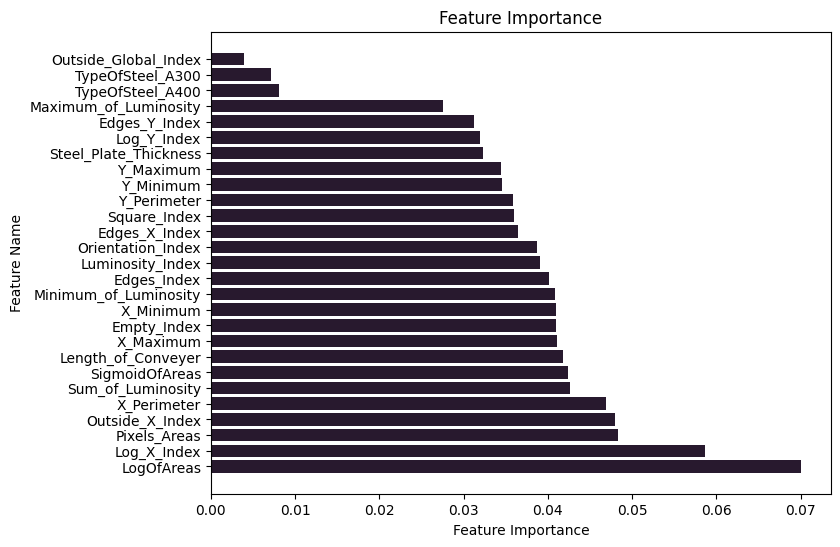

In [48]:
plt.figure(figsize=(8, 6))

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])

plt.xlabel('Feature Importance')

plt.ylabel('Feature Name')

plt.title('Feature Importance')

plt.show()

<a name='7'> </a>



# 7-Modeling

## Models Training

In [49]:
%%capture

model_name = []

roc_auc_scores = []

mean_roc_scores=[]

accuracy_scores = []

mean_accuracy_scores = []

models = [

    DecisionTreeClassifier(random_state=42),

    RandomForestClassifier(random_state=42),

    GradientBoostingClassifier(random_state=42),

    ExtraTreesClassifier(random_state=42),

    AdaBoostClassifier(random_state=42),

    LGBMClassifier(random_state=42),

    LogisticRegression(random_state=42),

    XGBClassifier(random_state=42),

    CatBoostClassifier(random_state=42)

]

TARGETS = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

for model in models:

    roc_auc_scores_model = []  # List to store ROC scores for the current model

    accuracy_scores_model = [] # List to store Accuracy scores for the current model

    for defect_category in TARGETS:

        f1.update_c(defect_category)

        X_ft_train_res, y_ft_train_res = f1.fit_resample(X_ft_train, y_ft_train)

        model.fit(X_ft_train_res, y_ft_train_res)

        model.fit(X_ft_train, y_ft_train[defect_category])

        y_predict_proba = model.predict_proba(X_ft_valid)[:, 1]
        
        y_predict = model.predict(X_ft_valid)
        
        roc_auc = roc_auc_score(y_ft_valid[defect_category], y_predict_proba) * 100
        
        accuracy = accuracy_score(y_ft_valid[defect_category], y_predict) * 100
        
        roc_auc_scores_model.append(roc_auc) # Append ROC score to the list for the current model

        accuracy_scores_model.append(accuracy) # Append Accuracy score to the list for the current model

    
    model_name.append(model.__class__.__name__)  # Append the list of ROC scores for the current model

    roc_auc_scores.append(np.mean(roc_auc_scores_model))  # Append the list of ROC scores for the current model
    accuracy_scores.append(np.mean(accuracy_scores_model))  # Append the list of Accuracy scores for the current model

In [50]:
for name, mean_roc_score in zip(model_name, roc_auc_scores):

    print(f"Mean ROC Score for {name}: {mean_roc_score}%")

print('\n-----------------------------------------------------\n')

for name, mean_accuracy_score in zip(model_name, accuracy_scores):

    print(f"Mean Accuracy Score for {name}: {mean_accuracy_score}%")

Mean ROC Score for DecisionTreeClassifier: 67.21368047470627%
Mean ROC Score for RandomForestClassifier: 85.7739000194468%
Mean ROC Score for GradientBoostingClassifier: 86.63280740936412%
Mean ROC Score for ExtraTreesClassifier: 85.4691394335803%
Mean ROC Score for AdaBoostClassifier: 85.65419379763655%
Mean ROC Score for LGBMClassifier: 86.4340325007403%
Mean ROC Score for LogisticRegression: 84.0353053860873%
Mean ROC Score for XGBClassifier: 85.43001315750173%
Mean ROC Score for CatBoostClassifier: 86.51687759486332%

-----------------------------------------------------

Mean Accuracy Score for DecisionTreeClassifier: 84.27481294286706%
Mean Accuracy Score for RandomForestClassifier: 88.5213814974481%
Mean Accuracy Score for GradientBoostingClassifier: 88.821168425747%
Mean Accuracy Score for ExtraTreesClassifier: 88.40245775729646%
Mean Accuracy Score for AdaBoostClassifier: 88.66260343887814%
Mean Accuracy Score for LGBMClassifier: 88.73197562063328%
Mean Accuracy Score for Logi

##  Plot Model Performace

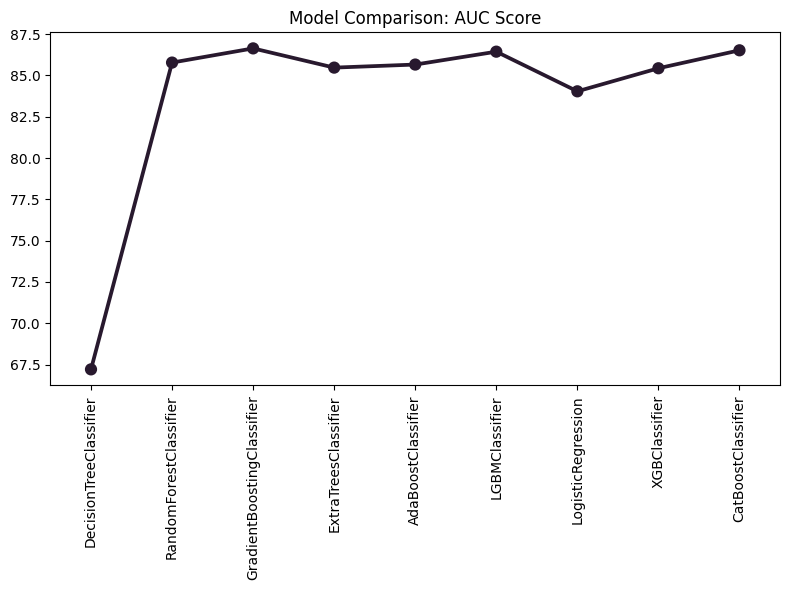

In [51]:
plt.figure(figsize=(8,6))

sns.pointplot(x=model_name,y=roc_auc_scores)

plt.xticks(rotation=90)

plt.title('Model Comparison: AUC Score')

plt.tight_layout()

plt.show()

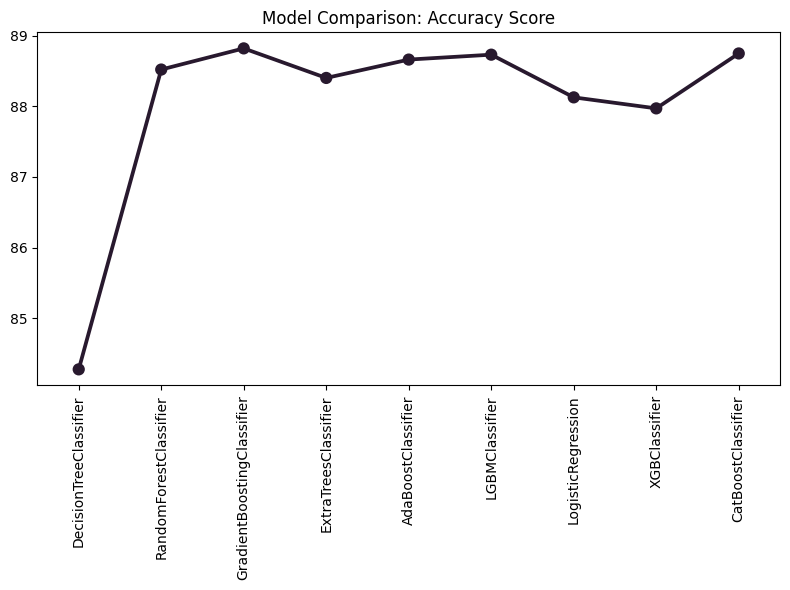

In [52]:
plt.figure(figsize=(8,6))

sns.pointplot(x=model_name,y=accuracy_scores)

plt.xticks(rotation=90)

plt.title('Model Comparison: Accuracy Score')

plt.tight_layout()

plt.show()

<a name='8'> </a>

# 8-Final Model

In [53]:
#Best Competition Score

model=CatBoostClassifier(random_state=42)

## Hyperparameter Optimization

In [56]:
def objective(trial, X_train, y_train, X_val, y_val, defect_category):
    """The objective function to optimize hyperparameters. It evaluate the AUC score on a
    validation set. This function is used by Optuna, a hyperparameters optimization framework.
    
    Args:
        trial (Trial): A trial is a process of evaluating an objective function.
        X_train (ndarray): The train data to use during hyperparameters optimization.
        y_train (ndarray): The train target labels to use during hyperparameters optimization.
        X_val (ndarray): The validation data to use during hyperparameters optimization.
        y_tval (ndarray): The validation target labels to use during hyperparameters optimization.
        c (int): The class index to use during training based on the onehot encoded targets.
        
    Returns:
        float: The validation accuracy score.
    """
    
    # Define user attributes
    trial.set_user_attr('objective', 'Logloss')
    trial.set_user_attr('eval_metric', 'auc')
    trial.set_user_attr('thread_count', -1)
    trial.set_user_attr('verbose', 0)
    trial.set_user_attr('random_seed', 42)

    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
    
    # Define the model parameters (with tunable hyperparameters)
    params = {
        'objective': trial.user_attrs['objective'],
        'boosting_type': trial.suggest_categorical('boosting_type', ["Ordered", "Plain"]),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int("od_wait", 10, 100),
        'bootstrap_type': bootstrap_type,
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 5, 12, step=1),
        'random_seed': trial.user_attrs['random_seed'],
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10, step=0.1),
        'random_strength': trial.suggest_float('random_strength', 0, 10, step=0.1),
        'border_count': trial.suggest_int('border_count', 32, 255, step=32),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1, step=0.01), 
        'verbose': trial.user_attrs['verbose'],
    }

    if bootstrap_type == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 1, step=0.1)
    elif bootstrap_type == 'Bernoulli':
        params['subsample'] = trial.suggest_float("subsample", 0.1, 1, step=0.1)
        
    clf = CatBoostClassifier(task_type='CPU',**params)

    f1.update_c(defect_category)
    X_ft_train_res, y_ft_train_res = f1.fit_resample(X_ft_train, y_ft_train)
    X_ft_train_res, y_ft_train_res = shuffle(X_ft_train_res, y_ft_train_res)
    clf.fit(X_ft_train_res, y_ft_train_res)

    y_preds = clf.predict_proba(X_ft_valid)[:, 1]

    score = roc_auc_score(y_ft_valid[defect_category], y_preds)

    # Future improvement: add cross validation with shuffle for more rightful scoring 
    # n_splits = 5
    # kf = KFold(n_splits=n_splits, shuffle=True)
    # score = cross_val_score(clf, X_ft_train_res, y_ft_train_res, cv=kf, scoring='roc_auc')
    
    return score

In [59]:
# Set the level of verbosity
optuna.logging.set_verbosity(optuna.logging.ERROR)

studies_results = {}

# Optimize hyperparameters
for c in TARGETS:
    # Create a study with Optuna
    study = optuna.create_study(sampler=TPESampler(), direction='maximize', study_name=f'hyperparameters_tuning_{c}')
    study.optimize(
        lambda trial: objective(trial, X_ft_train, y_ft_train, X_ft_valid, y_ft_valid, c), 
        n_trials=100, 
        timeout=600, 
        n_jobs=-1
    )
    
    print(f"Best trial reach a validation AUC score of: {study.best_value * 100:.2f}% for the class {c}")
    studies_results[f'study_{c}'] = study.best_params

Best trial reach a validation AUC score of: 76.28% for the class Pastry
Best trial reach a validation AUC score of: 95.38% for the class Z_Scratch
Best trial reach a validation AUC score of: 98.16% for the class K_Scatch
Best trial reach a validation AUC score of: 99.34% for the class Stains
Best trial reach a validation AUC score of: 87.34% for the class Dirtiness
Best trial reach a validation AUC score of: 80.94% for the class Bumps
Best trial reach a validation AUC score of: 69.65% for the class Other_Faults


In [60]:
# Display study best params (pretty display using json)
import json
print(json.dumps(studies_results, indent=2))

{
  "study_Pastry": {
    "bootstrap_type": "Bernoulli",
    "boosting_type": "Plain",
    "od_type": "Iter",
    "od_wait": 23,
    "learning_rate": 0.005391482131885891,
    "iterations": 700,
    "depth": 12,
    "l2_leaf_reg": 3.7,
    "random_strength": 4.3,
    "border_count": 224,
    "colsample_bylevel": 0.08,
    "subsample": 0.2
  },
  "study_Z_Scratch": {
    "bootstrap_type": "Bernoulli",
    "boosting_type": "Ordered",
    "od_type": "Iter",
    "od_wait": 47,
    "learning_rate": 0.019066538664362184,
    "iterations": 600,
    "depth": 12,
    "l2_leaf_reg": 3.4000000000000004,
    "random_strength": 6.2,
    "border_count": 160,
    "colsample_bylevel": 0.09,
    "subsample": 0.4
  },
  "study_K_Scatch": {
    "bootstrap_type": "Bayesian",
    "boosting_type": "Ordered",
    "od_type": "IncToDec",
    "od_wait": 54,
    "learning_rate": 0.003476951438691942,
    "iterations": 600,
    "depth": 8,
    "l2_leaf_reg": 6.6000000000000005,
    "random_strength": 2.0,
    "bo

## Metric Evaluation on Validation Data 

In [61]:
from sklearn.metrics import roc_curve

def find_optimal_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

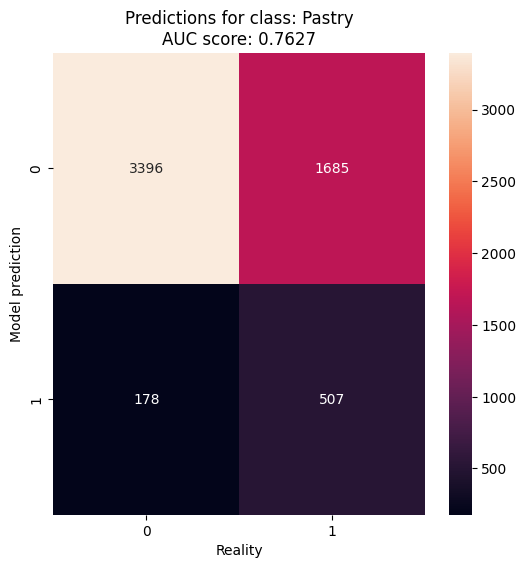

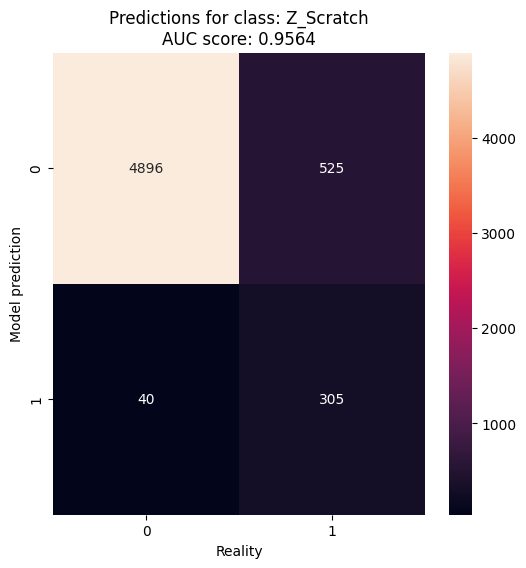

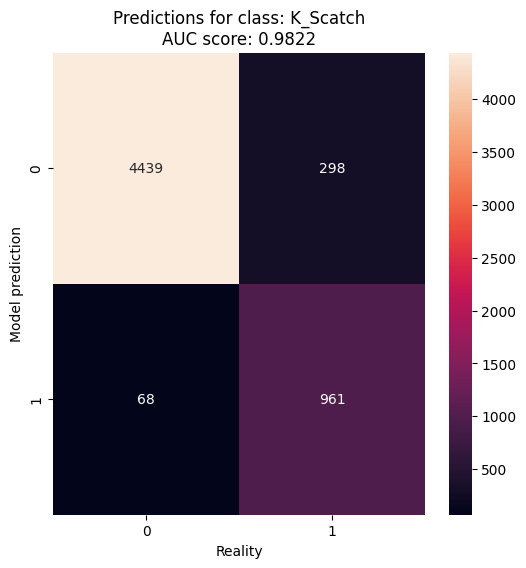

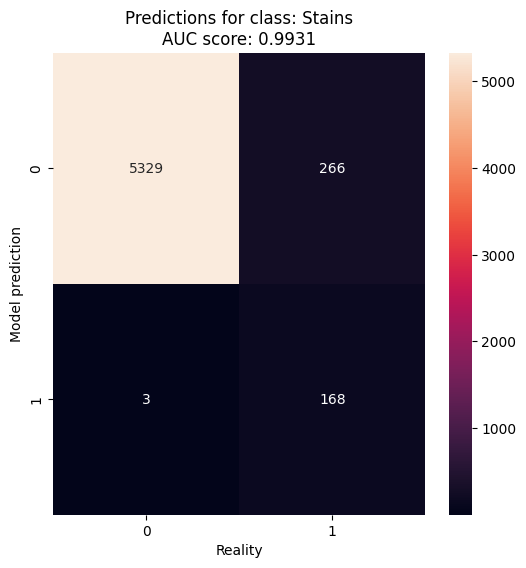

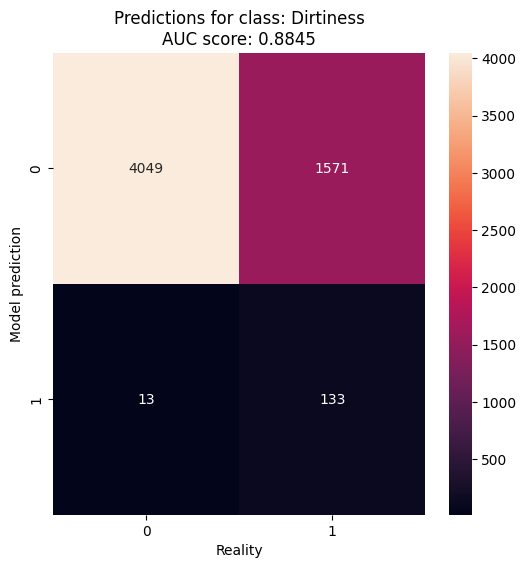

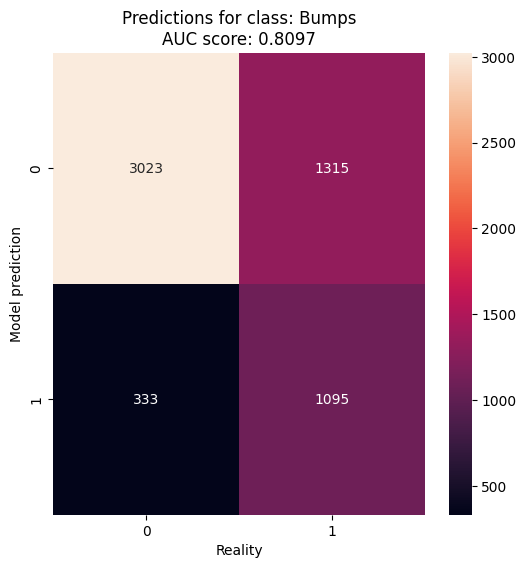

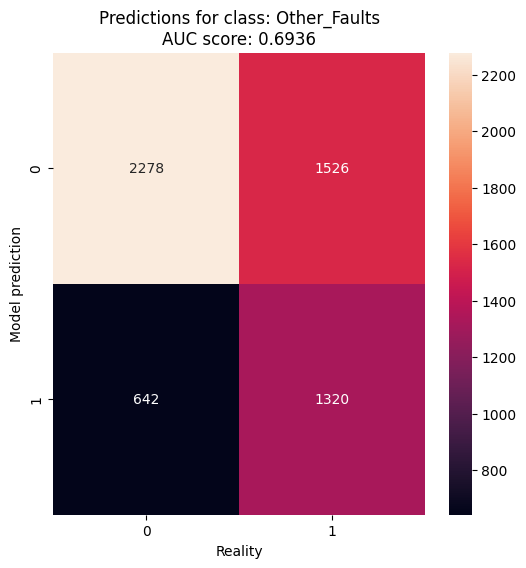

In [62]:
model_results = {}
roc_auc_scores = []

for c in TARGETS:
    # Get the best params from the study and add fix user attributes
    best_params = studies_results.get(f'study_{c}')
    params = {**best_params, **{
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'thread_count': -1, 
        'verbose': 0, 
        'random_seed': 42}
    }
    
    # Create the model with the optimal hyperparameters
    clf = CatBoostClassifier(**params)
    
    # Train the model
    clf.fit(X_ft_train, y_ft_train[c])
    
    # Store the model
    model_results[c] = clf
    
    # Get predictions on validation set
    y_preds = clf.predict(X_ft_valid)
    
    # Get predictions probabilities on validation set
    y_preds_proba = clf.predict_proba(X_ft_valid)[:, 1]

    opt_th = find_optimal_threshold(y_ft_valid[c], y_preds_proba)
    
    #AUC score
    auc_score = roc_auc_score(y_ft_valid[c], y_preds_proba)
    roc_auc_scores.append(auc_score)
    
    plt.figure(figsize=(6,6))
    plt.title(f"Predictions for class: {c}\nAUC score: {auc_score:.4f}")
    sns.heatmap(confusion_matrix(y_ft_valid[c], y_preds_proba > opt_th), annot=True, fmt = 'g')
    plt.xlabel("Reality")
    plt.ylabel("Model prediction")
    plt.show()

In [63]:
average_roc_auc = np.mean(roc_auc_scores)
print(f"Average ROC AUC across all classes: {average_roc_auc:.4f}")

Average ROC AUC across all classes: 0.8689


## Prediction for Test Data

In [64]:
# Use each model to predict the classes
predictions = {}

for name, model in model_results.items():
    print(f"Prediction for class: {name} done!")
    preds = model.predict_proba(X_1_test_f1)[:, 1]
    
    predictions[name] = preds

Prediction for class: Pastry done!
Prediction for class: Z_Scratch done!
Prediction for class: K_Scatch done!
Prediction for class: Stains done!
Prediction for class: Dirtiness done!
Prediction for class: Bumps done!
Prediction for class: Other_Faults done!


In [65]:
# Transform predictions into a DataFrame for submission
df_preds = pd.DataFrame(predictions)

In [66]:
df_preds.head(20)

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.302467,0.004182,0.026716,0.000182,0.007229,0.136306,0.391083
1,0.256345,0.020243,0.057791,0.000506,0.144526,0.147924,0.314350
2,0.082573,0.073580,0.083805,0.002920,0.001801,0.239206,0.505728
3,0.132541,0.001273,0.011923,0.003106,0.003537,0.386545,0.437026
4,0.070369,0.003838,0.018568,0.002545,0.011182,0.506227,0.335791
5,0.145619,0.359293,0.028282,0.000153,0.007095,0.221232,0.156941
6,0.344986,0.002640,0.037578,0.000114,0.016901,0.051489,0.601445
7,0.122830,0.104719,0.034333,0.006591,0.029672,0.171934,0.489679
8,0.065966,0.199011,0.128688,0.004975,0.002774,0.186238,0.276204
9,0.250286,0.012065,0.011001,0.000072,0.001418,0.242804,0.508392
